In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_force = pd.read_csv('/content/drive/MyDrive/force_logs.csv')
df_taranaki = pd.read_csv('/content/drive/MyDrive/taranaki_logs.csv')
df_kansas = pd.read_csv('/content/drive/MyDrive/kansas_logs.csv')

In [ ]:
df_force = df_force.rename(columns={'UWI': 'WELLNAME'})
df_taranaki = df_taranaki.rename(columns={'DENS': 'RHOB', 'NEUT': 'NPHI'})
df_kansas = df_kansas.rename(columns={'UWI': 'WELLNAME'})

In [ ]:
df_force.set_index(['WELLNAME', 'DEPT'], inplace = True)
df_taranaki.set_index(['WELLNAME', 'DEPT'], inplace = True)
df_kansas.set_index(['WELLNAME', 'DEPT'], inplace = True)

In [ ]:
print(f'Количество скважин Taranaki = {df_taranaki.index.get_level_values(0).nunique()}')
print(f'Количество скважин Force = {df_force.index.get_level_values(0).nunique()}')
print(f'Количество скважин Kansas = {df_kansas.index.get_level_values(0).nunique()}')

Количество скважин Taranaki = 152
Количество скважин Force = 110
Количество скважин Kansas = 93


In [ ]:
X_taranaki = df_taranaki.drop('GR', axis = 1)
y_taranaki = df_taranaki['GR']

X_kansas = df_kansas.drop('GR', axis = 1)
y_kansas = df_kansas['GR']

X_force = df_force.drop(['GR'], axis = 1)
y_force = df_force['GR']

In [ ]:
df_X = pd.concat([X_taranaki, X_kansas, X_force])
df_y = pd.concat([y_taranaki, y_kansas, y_force])

In [ ]:
X = df_X.reset_index()
y = df_y.reset_index()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

normalized_values_X = scaler_X.fit_transform(X[['CALI', 'RHOB', 'DRHO', 'NPHI', 'SP']])
normalized_values_y = scaler_y.fit_transform(y[['GR']])

X[['CALI', 'RHOB', 'DRHO', 'NPHI', 'SP']] = normalized_values_X
y[['GR']] = normalized_values_y

X_scaled = X.set_index(['WELLNAME', 'DEPT'])
y_scaled = y.set_index(['WELLNAME', 'DEPT'])

In [ ]:
X_kansas = X_scaled.loc[X_kansas.index.get_level_values(0).unique()]
y_kansas = y_scaled.loc[y_kansas.index.get_level_values(0).unique()]

In [ ]:
train_part_size = 0.7

rd.seed(10)
train_wells_kansas = rd.sample(
    X_kansas.index.get_level_values(0).unique().tolist(),
    round(len(X_kansas.index.get_level_values(0).unique()) * train_part_size),
)

val_test_wells_kansas = list(set(X_kansas.index.get_level_values(0).unique().tolist()) - set(train_wells_kansas))
val_test_wells_kansas = sorted(val_test_wells_kansas)
rd.shuffle(val_test_wells_kansas)

rd.seed(10)
val_wells_kansas = rd.sample(
    val_test_wells_kansas,
    round(len(val_test_wells_kansas) * 0.5),)

test_wells_kansas = list(set(val_test_wells_kansas) - set(val_wells_kansas))
test_wells_kansas = sorted(test_wells_kansas)
rd.shuffle(test_wells_kansas)

In [ ]:
train_X_kansas = X_kansas.loc[train_wells_kansas]
train_y_kansas = y_kansas.loc[train_wells_kansas]

val_X_kansas = X_kansas.loc[val_wells_kansas]
val_y_kansas = y_kansas.loc[val_wells_kansas]

test_X_kansas = X_kansas.loc[test_wells_kansas]
test_y_kansas = y_kansas.loc[test_wells_kansas]

In [ ]:
def gen_data_per_well(features, target, time_steps=50):
    Xs, ys = [], []

    # Перебираем уникальные значения скважин
    for well_name in features.index.get_level_values('WELLNAME').unique():
        # Получаем данные для текущей скважины
        well_features = features.xs(well_name, level='WELLNAME')
        well_target = target.xs(well_name, level='WELLNAME')

        # Генерируем X и y для текущей скважины
        for i in range(len(well_features) - time_steps):
            Xs.append(well_features.iloc[i:i + time_steps].values)
            ys.append(well_target.iloc[i + time_steps - 1])

    return np.array(Xs), np.array(ys)

In [ ]:
train_X_kansas, train_y_kansas = gen_data_per_well(train_X_kansas, train_y_kansas)
val_X_kansas, val_y_kansas = gen_data_per_well(val_X_kansas, val_y_kansas)
test_X_kansas, test_y_kansas = gen_data_per_well(test_X_kansas, test_y_kansas)

In [ ]:
train_X_kansas_tensor = torch.tensor(train_X_kansas, dtype=torch.float32)
train_y_kansas_tensor = torch.tensor(train_y_kansas, dtype=torch.float32)

val_X_kansas_tensor = torch.tensor(val_X_kansas, dtype=torch.float32)
val_y_kansas_tensor = torch.tensor(val_y_kansas, dtype=torch.float32)

test_X_kansas_tensor = torch.tensor(test_X_kansas, dtype=torch.float32)
test_y_kansas_tensor = torch.tensor(test_y_kansas, dtype=torch.float32)

In [ ]:
# Создание TensorDataset
train_dataset = TensorDataset(train_X_kansas_tensor, train_y_kansas_tensor)
val_dataset = TensorDataset(val_X_kansas_tensor, val_y_kansas_tensor)
test_dataset = TensorDataset(test_X_kansas_tensor, test_y_kansas_tensor)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.conv4 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=5, padding='same')
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(kernel_size=2)

        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.1435846)

        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.dropout2 = nn.Dropout(0.0744927)

        self.lstm3 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.dropout3 = nn.Dropout(0.230377)

        self.lstm4 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout4 = nn.Dropout(0.096458)

        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Теперь x имеет форму (batch_size, features_dim, time_steps)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.ReLU()(x)
        x = self.pool4(x)

        # Сначала нужно изменить размерность для LSTM
        x = x.transpose(1, 2)  # Меняем местами размерности (batch_size, num_channels, sequence_length) -> (batch_size, sequence_length, num_channels)

        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)
        x = self.dropout3(x)

        x, _ = self.lstm4(x)
        x = self.dropout4(x)

        # Берем только последний выход LSTM
        x = x[:, -1, :]  # (batch_size, hidden_size)

        x = self.fc(x)

        return x

In [ ]:
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=0.0006)
criterion = nn.MSELoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience=4, lr_reduce_factor=0.5):
    model.to(device)  # Перемещаем модель на GPU

    best_val_loss = float('inf')  # Наименьшая валидационная потеря
    epochs_without_improvement = 0  # Счетчик эпох без улучшения
    best_weights = None  # Переменная для хранения лучших весов

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # В режим тренировки
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на GPU
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(inputs)  # Прямой проход
            loss = criterion(outputs, targets)  # Вычисление потерь
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновление весов

            train_loss += loss.item()  # Суммируем потери для тренировки

        train_loss /= len(train_loader)  # Среднее значение по всем батчам
        train_losses.append(train_loss)

        # Валидация
        model.eval()  # В режим валидации
        val_loss = 0.0
        with torch.no_grad():  # Отключаем градиенты
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Перемещаем данные на GPU
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Среднее значение по всем батчам
        val_losses.append(val_loss)

        # Если текущая валидационная потеря лучше, сохраняем веса
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()  # Сохраняем лучшие веса
            epochs_without_improvement = 0  # Сбрасываем счетчик
        else:
            epochs_without_improvement += 1  # Увеличиваем счетчик без улучшений

        # Изменяем скорость обучения, если не было улучшения
        if epochs_without_improvement > 0 and epochs_without_improvement % 2 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_reduce_factor  # Уменьшаем lr в 2 раза

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Проверяем, нужно ли остановить обучение
        if epochs_without_improvement >= patience:
            print(f'Stopping early at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}')
            break

    # Восстанавливаем лучшие веса
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print("Loaded best weights.")

    return train_losses, val_losses

In [ ]:
def get_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.append(outputs.cpu().numpy())
            true_values.append(batch_y.cpu().numpy())
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    return predictions, true_values

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, num_epochs=50)

Epoch 1/50, Train Loss: 0.0022, Val Loss: 0.0023
Epoch 2/50, Train Loss: 0.0016, Val Loss: 0.0021
Epoch 3/50, Train Loss: 0.0014, Val Loss: 0.0021
Epoch 4/50, Train Loss: 0.0014, Val Loss: 0.0021
Epoch 5/50, Train Loss: 0.0013, Val Loss: 0.0021
Epoch 6/50, Train Loss: 0.0012, Val Loss: 0.0020
Epoch 7/50, Train Loss: 0.0012, Val Loss: 0.0020
Epoch 8/50, Train Loss: 0.0012, Val Loss: 0.0020
Epoch 9/50, Train Loss: 0.0011, Val Loss: 0.0020
Epoch 10/50, Train Loss: 0.0011, Val Loss: 0.0020
Epoch 11/50, Train Loss: 0.0010, Val Loss: 0.0020
Epoch 12/50, Train Loss: 0.0010, Val Loss: 0.0020
Epoch 13/50, Train Loss: 0.0010, Val Loss: 0.0020
Epoch 14/50, Train Loss: 0.0010, Val Loss: 0.0021
Epoch 15/50, Train Loss: 0.0010, Val Loss: 0.0020
Epoch 16/50, Train Loss: 0.0010, Val Loss: 0.0020
Stopping early at epoch 16. Best Val Loss: 0.0020
Loaded best weights.


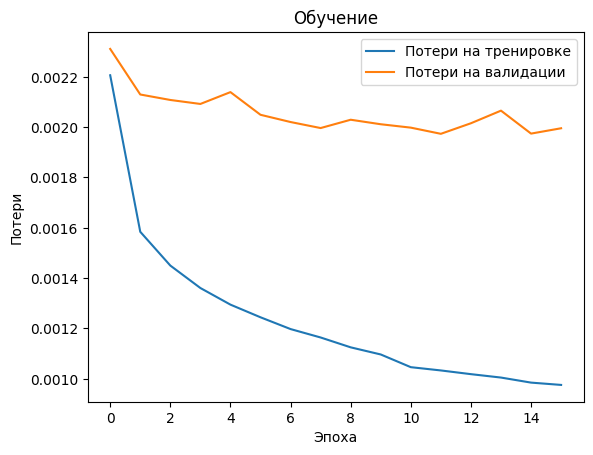

In [ ]:
plt.plot(train_losses, label='Потери на тренировке')
plt.plot(val_losses, label='Потери на валидации')
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

In [ ]:
predictions, true_values = get_predictions(model, test_loader, device)

In [ ]:
mae = mean_absolute_error(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

In [ ]:
print(f"MAE: {mae}",
      f"MAPE: {mape}",
      f"RMSE: {rmse}",
      f"R2: {r2}", sep = '\n')

MAE: 0.024959290886293655
MAPE: 0.3437483953304684
RMSE: 0.038685284169491865
R2: 0.6910038478717615


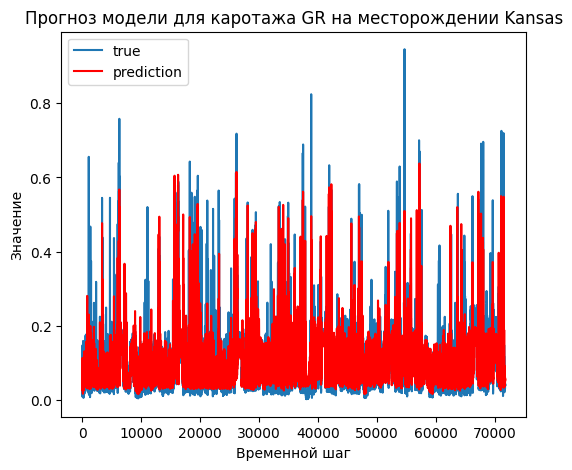

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(true_values, label="true")
plt.plot(predictions, 'r', label="prediction")
plt.title('Прогноз модели для каротажа GR на месторождении Kansas')
plt.ylabel('Значение')
plt.xlabel('Временной шаг')
plt.legend()
plt.show()

In [ ]:
np.save('pred_1.npy', predictions)

In [ ]:
for i in range(9):
    print(f"\nTraining iteration {i + 1}/9")

    # Создаем новую модель и оптимизатор для каждой итерации
    model = MyModel()
    optimizer = optim.Adam(model.parameters(), lr=0.0006)
    criterion = nn.MSELoss()

    # Обучаем модель
    train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, num_epochs=50)

    # Получаем предсказания на тестовом наборе
    predictions, _ = get_predictions(model, test_loader, device)

    # Сохраняем предсказания текущей итерации
    np.save(f'pred_{i + 2}.npy', predictions)